In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

### **Imports**

In [2]:
import sys

sys.path.append("../")

In [3]:
from apps.dataframe_transforms import init_spark, denormalize_store_sales

In [5]:
spark = init_spark("EDA")
spark.conf.set("spark.sql.debug.maxToStringFields", 1000)
spark.sparkContext.setLogLevel("WARN")

In [6]:
src_store_sales = "../data/csv/store_sales.csv"
src_store = "../data/csv/store.csv"
src_items = "../data/csv/item.csv"
src_date = "../data/csv/date_dim.csv"
src_time = "../data/csv/time_dim.csv"

df_store_sales = spark.read.option("header", "true").csv(src_store_sales)
df_store = spark.read.option("header", "true").csv(src_store)
df_items = spark.read.option("header", "true").csv(src_items)
df_date = spark.read.option("header", "true").csv(src_date)
df_time = spark.read.option("header", "true").csv(src_time)

In [7]:
from pyspark.sql.types import IntegerType

### **Preprocessing**

#### **Denormalize store sales**


In [48]:
df = denormalize_store_sales(df_store, df_store_sales, df_items, df_date, df_time)

In [49]:
columns_to_select = [
    "t_am_pm",
    "t_hour",
    "t_shift",
    "i_class",
    "i_category",
    "i_color",
    "s_store_name",
    "s_number_employees",
    "s_floor_space",
    "s_hours",
    "s_country",
    "s_city",
    "ss_sales_price",
    "ss_quantity",
    "d_date",
    "d_quarter_name",
    "d_holiday",
    "d_year",
    "d_weekend",
    "d_following_holiday",
    "d_first_dom",
    "d_last_dom",
    "d_current_day",
    "d_current_week",
    "d_current_month",
    "d_current_quarter",
    "d_current_year",
]

#### **Check for Null values**

In [10]:
from pyspark.sql.functions import isnan, when, count, col

In [50]:
df_processed = df.select(*columns_to_select)

In [56]:
df_processed.select("d_year").show(10)

+------+
|d_year|
+------+
|  2000|
|  2000|
|  2000|
|  2000|
|  2000|
|  2000|
|  2000|
|  2000|
|  2000|
|  2000|
+------+
only showing top 10 rows



In [55]:
df_null = df_processed.select(
    [count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_processed.columns]
).show(vertical=True)

df_null

-RECORD 0----------------------
 t_am_pm             | 648574  
 t_hour              | 648574  
 t_shift             | 648574  
 i_class             | 37975   
 i_category          | 33025   
 i_color             | 38146   
 s_store_name        | 648113  
 s_number_employees  | 1158293 
 s_floor_space       | 1158293 
 s_hours             | 648113  
 s_country           | 648113  
 s_city              | 1158293 
 ss_sales_price      | 648525  
 ss_quantity         | 647686  
 d_date              | 648638  
 d_quarter_name      | 648638  
 d_holiday           | 648638  
 d_year              | 648638  
 d_weekend           | 648638  
 d_following_holiday | 648638  
 d_first_dom         | 648638  
 d_last_dom          | 648638  
 d_current_day       | 648638  
 d_current_week      | 648638  
 d_current_month     | 648638  
 d_current_quarter   | 648638  
 d_current_year      | 648638  



#### **Drop rows with one or more null values**

In [57]:
df_processed.count()

14400052

In [60]:
df_processed = df_processed.na.drop()

In [61]:
df_processed.count()

12600139

### **Exploration**

#### **Which Stores perform best for each year**

In [13]:
df_processed.select("d_year").show(10)

+------+
|d_year|
+------+
|  2000|
|  2000|
|  2000|
|  2000|
|  2000|
|  2000|
|  2000|
|  2000|
|  2000|
|  2000|
+------+
only showing top 10 rows



In [66]:
from pyspark.sql.functions import count, avg, sum

In [68]:
df_processed.groupBy("s_store_name", "d_year").agg(
    sum("ss_sales_price"), count("*")
).show()

+------------+------+-------------------+--------+
|s_store_name|d_year|sum(ss_sales_price)|count(1)|
+------------+------+-------------------+--------+
|        able|  2003|             155212|    4146|
|         pri|  2000|            7294976|  195001|
|       ought|  1998|            7267377|  194337|
|        eing|  2001|           10866383|  290644|
|        eing|  1998|           10668886|  285254|
|       ation|  2000|            7074603|  190089|
|        able|  2000|           14528961|  388274|
|       ought|  2000|            7326920|  195667|
|        eing|  2003|             125000|    3323|
|       ought|  1999|            7257830|  194613|
|       ought|  2002|            7285156|  194727|
|       ought|  2003|              88005|    2356|
|        anti|  2003|              38493|    1009|
|        able|  1999|           14509259|  387787|
|        anti|  1999|            3586928|   95689|
|        able|  2001|           14595006|  390896|
|         pri|  1999|          

In [70]:
grouped_year_store = (
    df_processed.groupBy("s_store_name", "d_year")
    .agg(sum("ss_sales_price"), count("*"))
    .toPandas()
)

In [83]:
sns.set(rc={"figure.figsize": (15.7, 8.27)})

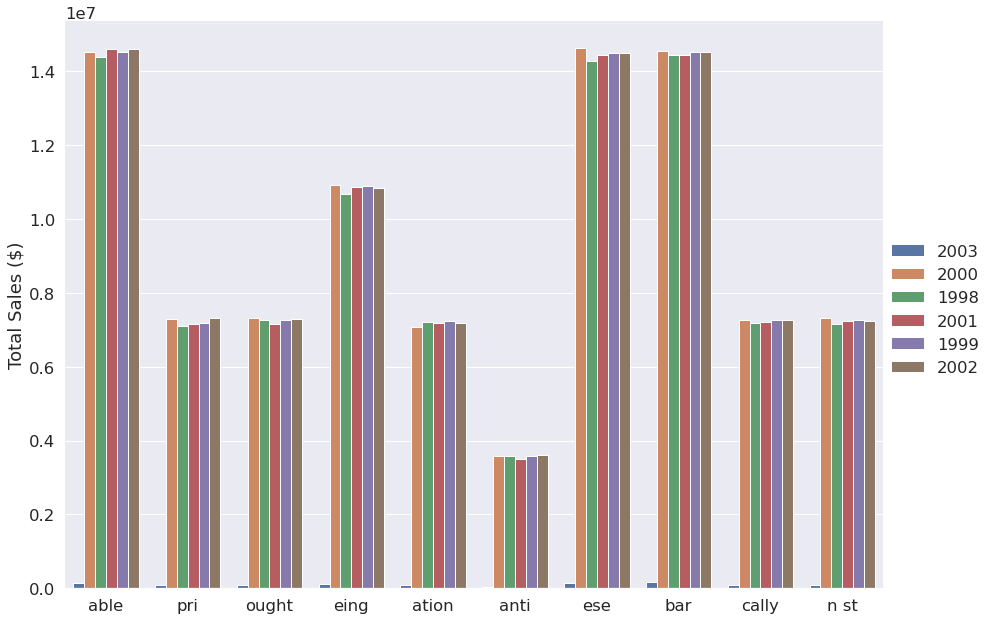

In [96]:
import seaborn as sns

sns.set(font_scale=1.5)

category_plot = sns.catplot(
    x="s_store_name",  # x variable name
    y="sum(ss_sales_price)",  # y variable name
    hue="d_year",  # group variable name
    data=grouped_year_store,  # dataframe to plot
    kind="bar",
    height=9.27,
    aspect=12.7 / 9.27,
)
category_plot.despine(left=True)
category_plot.set_axis_labels(
    "",
    "Total Sales ($)",
)
category_plot.legend.set_title("")

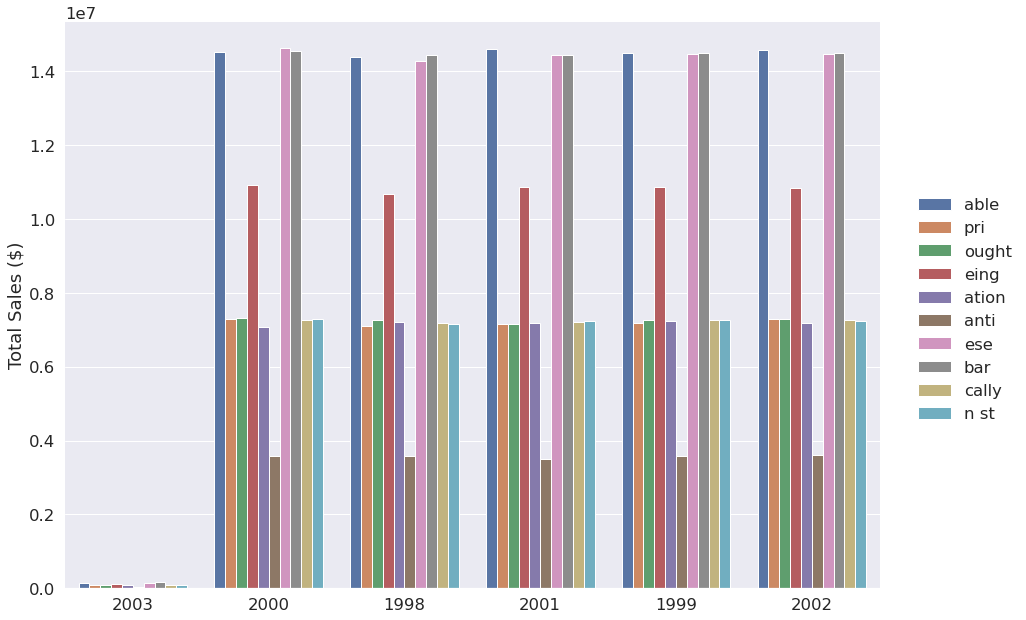

In [97]:
import seaborn as sns

sns.set(font_scale=1.5)

category_plot = sns.catplot(
    x="d_year",  # x variable name
    y="sum(ss_sales_price)",  # y variable name
    hue="s_store_name",  # group variable name
    data=grouped_year_store,  # dataframe to plot
    kind="bar",
    height=9.27,
    aspect=12.7 / 9.27,
)
category_plot.despine(left=True)
category_plot.set_axis_labels(
    "",
    "Total Sales ($)",
)
category_plot.legend.set_title("")

#### **Products**

In [108]:
df_processed.columns

['t_am_pm',
 't_hour',
 't_shift',
 'i_class',
 'i_category',
 'i_color',
 's_store_name',
 's_number_employees',
 's_floor_space',
 's_hours',
 's_country',
 's_city',
 'ss_sales_price',
 'ss_quantity',
 'd_date',
 'd_quarter_name',
 'd_holiday',
 'd_year',
 'd_weekend',
 'd_following_holiday',
 'd_first_dom',
 'd_last_dom',
 'd_current_day',
 'd_current_week',
 'd_current_month',
 'd_current_quarter',
 'd_current_year']

In [116]:
df_processed.select("i_category").show()

+-----------+
| i_category|
+-----------+
|      Women|
|      Women|
|        Men|
|       Home|
|    Jewelry|
|Electronics|
|      Books|
|    Jewelry|
|      Women|
|      Music|
|      Women|
|      Shoes|
|      Music|
|      Music|
|   Children|
|    Jewelry|
|      Women|
|      Shoes|
|      Music|
|      Books|
+-----------+
only showing top 20 rows



In [112]:
from pyspark.sql import functions as F

##### Number of unique categories

In [114]:
df_processed.select(F.countDistinct("i_category")).show()

+--------------------------+
|count(DISTINCT i_category)|
+--------------------------+
|                        10|
+--------------------------+



##### Number of purchases in each category

In [120]:
df_processed.groupBy("i_category").count().sort(F.desc("count")).show()

+-----------+-------+
| i_category|  count|
+-----------+-------+
|      Music|1295287|
|Electronics|1274198|
|      Women|1270462|
|      Shoes|1269244|
|      Books|1262500|
|       Home|1249917|
|    Jewelry|1249875|
|     Sports|1248697|
|   Children|1241281|
|        Men|1238678|
+-----------+-------+



##### Number of distinct classes

In [113]:
df_processed.select(F.countDistinct("i_class")).show()

+-----------------------+
|count(DISTINCT i_class)|
+-----------------------+
|                     99|
+-----------------------+



##### Sales per category

In [125]:
grouped_sales_per_cat = (
    df_processed.groupBy("i_category")
    .agg(F.sum("ss_sales_price").alias("sales"))
    .sort(F.desc("sales"))
    .toPandas()
)

In [126]:
grouped_sales_per_cat

,i_category,sales
0,Music,48495327
1,Electronics,47693416
2,Women,47474085
3,Shoes,47469993
4,Books,47197016
5,Jewelry,46738018
6,Home,46733628
7,Sports,46593539
8,Children,46354929
9,Men,46291839


#### **Country**

In [117]:
df_processed.groupBy("s_country").count().show()

+-------------+--------+
|    s_country|   count|
+-------------+--------+
|United States|12600139|
+-------------+--------+

